In [136]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import linprog
import random
import sys
import copy
import math

% matplotlib.inline

UsageError: Line magic function `%` not found.


In [137]:
def take_step(state, action):
		row, column = state[0], state[1]
		
		if(row==special_state_1[0] and column==special_state_1[1]):
			row_next = special_state_1_next[0]
			column_next = special_state_1_next[1]
			reward = 10
		elif(row==special_state_2[0] and column==special_state_2[1]):
			row_next = special_state_2_next[0]
			column_next = special_state_2_next[1]
			reward = 5
		else:
			if(action=='left'):
				if(column==0):
					reward = -1
					row_next, column_next = row, column
				else:
					reward = 0
					row_next = row
					column_next = column - 1
			elif(action=='right'):
				if(column==grid_size-1):
					reward = -1
					row_next, column_next = row, column
				else:
					reward = 0
					row_next = row
					column_next = column + 1
			elif(action=='up'):
				if(row==0):
					reward = -1
					row_next, column_next = row, column
				else:
					reward = 0
					row_next = row - 1
					column_next = column
			elif(action=='down'):
				if(row==grid_size-1):
					reward = -1
					row_next, column_next = row, column
				else:
					reward = 0
					row_next = row + 1
					column_next = column

		state_next = np.asarray([row_next, column_next])
		return state_next, reward

In [138]:
def grid_simulation_linear_system(): # question 1
	identity = np.identity(grid_size**2)
	b = np.zeros(grid_size**2)
	prob = 0.25
	for current_state in range(grid_size**2):
		row = current_state // grid_size
		column = current_state % grid_size
		state = np.asarray([row, column])
		for action in action_space:
			next_state, reward = take_step(state, action)
			next_state_cumm = next_state[0] * grid_size + next_state[1]
			identity[current_state, next_state_cumm] = identity[current_state, next_state_cumm] - discounted_reward_factor * prob
			b[current_state] = b[current_state] + prob * reward

	value = np.linalg.solve(identity, b)
	return value

In [139]:
grid_size = 5
special_state_1 = np.asarray([0, 1])
special_state_1_next = np.asarray([4, 1])
special_state_2 = np.asarray([0, 3])
special_state_2_next = np.asarray([2, 3])
discounted_reward_factor = 0.9
action_space = ['up', 'down', 'left', 'right']
v = grid_simulation_linear_system()
print('Value', v)

Value [ 3.30899634  8.78929186  4.42761918  5.32236759  1.49217876  1.52158807
  2.99231786  2.25013995  1.9075717   0.54740271  0.05082249  0.73817059
  0.67311326  0.35818621 -0.40314114 -0.9735923  -0.43549543 -0.35488227
 -0.58560509 -1.18307508 -1.85770055 -1.34523126 -1.22926726 -1.42291815
 -1.97517905]


In [115]:
def optimal_value_function():
    num_actions = 4
    num_states = grid_size ** 2
    matrix = np.zeros((num_actions*grid_size**2, grid_size**2))
    b = np.zeros(num_actions*grid_size**2)

    ################################## optimal state-value 

    for current_state in range(num_states):
        row = current_state // grid_size
        column = current_state % grid_size
        state = np.asarray([row, column])
        for action in range(len(action_space)):
            next_state, reward = take_step(state, action_space[action])
            next_state_cumm = next_state[0] * grid_size + next_state[1]
            matrix[num_actions*current_state+action, current_state] -= 1
            matrix[num_actions*current_state+action, next_state_cumm] += discounted_reward_factor
            b[num_actions*current_state+action] -= reward

    coefficients = np.ones(num_states)
    v = np.round(linprog(coefficients, matrix, b).x, 2)
    # print(v.x)

    ################################### optimal policy

    expected_returns = []
    policy_grid = []
    for current_state in range(num_states):
        row = current_state // grid_size
        column = current_state % grid_size
        state = np.asarray([row, column])
        expected_returns = []
        for action in range(len(action_space)):
            next_state, reward = take_step(state, action_space[action])
            next_state_cumm = next_state[0] * grid_size + next_state[1]
            expected_returns.append(reward + discounted_reward_factor * v[next_state_cumm])

        max_pi = max(expected_returns)
        max_count = expected_returns.count(max_pi) # IN CASE OF MULTIPLE COUNTS
        indices = np.where(expected_returns==max_pi)[0]
        cu = []
        for i in indices:
            if(i==0):
                cu.append('up ')
            if(i==1):
                cu.append('down ')
            if(i==2):
                cu.append('left ')
            if(i==3):
                cu.append('right ')
        policy_grid.append(cu)
    return v, policy_grid

In [116]:
v, policy = optimal_value_function()
print('Value', v.reshape(grid_size, grid_size))
print('Policy')
for i in range(len(policy)):
    print(policy[i], end=" ")
    if(i!=0 and (i+1)%(grid_size)==0):
        print()

Value [[21.98 24.42 21.98 19.42 17.48]
 [19.78 21.98 19.78 17.8  16.02]
 [17.8  19.78 17.8  16.02 14.42]
 [16.02 17.8  16.02 14.42 12.98]
 [14.42 16.02 14.42 12.98 11.68]]
Policy
['right '] ['up ', 'down ', 'left ', 'right '] ['left '] ['up ', 'down ', 'left ', 'right '] ['left '] 
['up ', 'right '] ['up '] ['up ', 'left '] ['left '] ['left '] 
['up ', 'right '] ['up '] ['up ', 'left '] ['up ', 'left '] ['up ', 'left '] 
['up ', 'right '] ['up '] ['up ', 'left '] ['up ', 'left '] ['up ', 'left '] 
['up ', 'right '] ['up '] ['up ', 'left '] ['up ', 'left '] ['up ', 'left '] 


In [141]:
act = [[-1, 0], [1, 0], [0, -1], [0, 1]]
actions = {'up':[-1, 0], 'down':[1, 0], 'left':[0, -1], 'right':[0, 1]}
grid_size = 4
num_actions = 4
num_states = grid_size * grid_size
prob = 0.25
discounted_reward_factor = 1.0

In [142]:
def take_step(row, col, action):
    row_ = row + action[0]
    col_ = col + action[1]
    reward = -1
    if((row, col)==(0,0) and (row, col)==(grid_size-1, grid_size-1)):
        return [row, col], 0
    elif(row_>=0 and row_<grid_size and col_>=0 and col_<grid_size):
        return [row_, col_], -1
    else:
        return [row, col], -1

def policy_iteration():
    # INITIALIZE V(S) AND A(S)
    Vs = np.zeros((grid_size, grid_size))
    pi = prob * np.ones((num_actions, grid_size, grid_size))
    iter = 0
    while(True):
        # POLICY EVALUATION
        while(True):
            delta = 0
            Vs_old = Vs.copy()
            for r in range(grid_size):
                for c in range(grid_size):
                    if((r, c)==(0,0) or (r, c)==(3, 3)):
                        # TERMINAL STATE
                        continue
                    v = Vs[r, c]
                    Vs_new = 0
                    action_index = -1
                    for a in actions.keys():
                        action_index += 1
                        next_state, reward = take_step(r, c, actions[a])
                        Vs_new += pi[action_index, r, c] * (reward + discounted_reward_factor * Vs[next_state[0], next_state[1]])
                    Vs[r, c] = Vs_new
                    delta = max(delta, abs(v-Vs[r, c]))
            if(delta < 0.0001):
                break
            
            if(iter%10==0):
                print("Iteration: ", iter)
                print('Difference between previous and current value function is : ', np.linalg.norm(Vs_old - Vs))
                print()
            iter += 1

        # POLICY IMPROVEMENT
        stable_policy = True
        policy = []
        for r in range(grid_size):
            for c in range(grid_size):
                summation = []
                old_action = pi[:, r, c].copy()
                for a in actions.keys():
                    next_state, reward = take_step(r, c, actions[a])
                    summation.append(1.0 * (reward + discounted_reward_factor * Vs[next_state[0], next_state[1]]))
                max_pi = max(summation)
                max_count = summation.count(max_pi) # IN CASE OF MULTIPLE COUNTS
                indices = np.where(summation==max_pi)[0]
                pi[:, r, c] = np.zeros((num_actions))
                cu = []
                for i in indices:
                    if((r, c)==(0,0) or (r, c)==(3, 3)):
                        cu.append('---- ')
                        # TERMINAL STATE
                        continue
                    pi[i, r, c] = 1.0/max_count
                    if(i==0):
                        cu.append('up ')
                    if(i==1):
                        cu.append('down ')
                    if(i==2):
                        cu.append('left ')
                    if(i==3):
                        cu.append('right ')
                policy.append(cu)
                if( not (old_action == pi[:, r, c]).all()):
                    stable_policy = False

        if(stable_policy==True):
            return Vs, pi, policy

In [105]:
v, p, policy = policy_iteration()
print('Value', v.reshape(grid_size, grid_size))
print('Policy')
for i in range(len(policy)):
    print(policy[i], end=" ")
    if(i!=0 and (i+1)%(grid_size)==0):
        print()

Iteration:  0
Difference between previous and current value function is :  5.766122522572036

Iteration:  10
Difference between previous and current value function is :  2.446230466082198

Iteration:  20
Difference between previous and current value function is :  1.0196738914812349

Iteration:  30
Difference between previous and current value function is :  0.424935441320615

Iteration:  40
Difference between previous and current value function is :  0.17708605754237206

Iteration:  50
Difference between previous and current value function is :  0.0737982024700002

Iteration:  60
Difference between previous and current value function is :  0.030754395706637752

Iteration:  70
Difference between previous and current value function is :  0.012816475518696007

Iteration:  80
Difference between previous and current value function is :  0.005341091604862473

Iteration:  90
Difference between previous and current value function is :  0.0022258271776756725

Iteration:  100
Difference between

In [143]:
def value_iteration():
    epsilon  = 0.00000000000000000001
    V = np.zeros((grid_size, grid_size))
    theta = 0
    pi = np.zeros((num_actions, grid_size, grid_size))
    iter = 0
    
    # EVALUATION
    while(True):
        theta = 0
        V_old = V.copy()
        for r in range(grid_size):
            for c in range(grid_size):
                if((r, c)==(0,0) or (r, c)==(3, 3)):
                    # TERMINAL STATE
                    continue
                v = V[r, c]
                max_val = -sys.maxsize -1
                for a in actions.keys():
                    next_state, reward = take_step(r, c, actions[a])
                    val = 1.0 * (reward + discounted_reward_factor * V[next_state[0], next_state[1]])
                    if(val>max_val):
                        max_val = val
                V[r, c] = max_val
                theta = max(theta, abs(v-V[r, c]))

        print("Iteration: ", iter)
        print('Difference between previous and current value function is : ', np.linalg.norm(V_old - V))
        iter += 1
        
        if(theta<epsilon):
            break

    # IMPROVEMENT
    policy = []
    for r in range(grid_size):
        for c in range(grid_size):
            summation = []
            for a in actions.keys():
                next_state, reward = take_step(r, c, actions[a])
                summation.append(1.0 * (reward + discounted_reward_factor * V[next_state[0], next_state[1]]))
            max_pi = max(summation)
            max_count = summation.count(max_pi) # IN CASE OF MULTIPLE COUNTS
            indices = np.where(summation==max_pi)[0]
            cu = []
            for i in indices:
                if((r, c)==(0,0) or (r, c)==(3, 3)):
                    cu.append('----')
                    # TERMINAL STATE
                    continue
                pi[i, r, c] = 1.0/max_count
                if(i==0):
                    cu.append('up ')
                if(i==1):
                    cu.append('down ')
                if(i==2):
                    cu.append('left ')
                if(i==3):
                    cu.append('right ')
            policy.append(cu)
    return V, pi, policy

In [144]:
v, p, policy = value_iteration()
print('Value', v.reshape(grid_size, grid_size))
print('Policy')
print()
for i in range(len(policy)):
    print(policy[i], end=" ")
    if(i!=0 and (i+1)%(grid_size)==0):
        print()

Iteration:  0
Difference between previous and current value function is :  3.7416573867739413
Iteration:  1
Difference between previous and current value function is :  3.1622776601683795
Iteration:  2
Difference between previous and current value function is :  2.0
Iteration:  3
Difference between previous and current value function is :  0.0
Value [[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]
Policy

['----', '----'] ['left '] ['left '] ['down ', 'left '] 
['up '] ['up ', 'left '] ['up ', 'down ', 'left ', 'right '] ['down '] 
['up '] ['up ', 'down ', 'left ', 'right '] ['down ', 'right '] ['down '] 
['up ', 'right '] ['right '] ['right '] ['----', '----'] 


In [131]:
max_no_of_cars = 20
discounted_reward_factor = 0.9
max_cars_moving = 5
rental_cost = 10
moving_cost = -2
num_states = max_no_of_cars + 1
actions = np.arange(-max_cars_moving+1, max_cars_moving+1)
num_actions = 10#2 * max_cars_moving + 1
states = np.zeros((num_states, num_states))
lambda_requests = [3, 4]
lambda_returns = [3, 2]
max_cars_in_parking = 10
parking_extra_cost = 4

In [132]:
def factorial(n):
	fac = 1
	for i in range(1, n+1):
		fac *= i
	return fac

def poisson(lambda_, n):
	return math.pow(lambda_, n) * math.exp(-lambda_) * 1.0 / factorial (n)

def take_step(state, action, V):
	if(action > 0): #car moves from A to B
		cost = moving_cost * (action-1) #as one free shuttle is permitted
	else:
		cost = moving_cost * abs(action)
	ret = cost
	for i in range(6): #cars requested from location A
		for j in range(6): #cars requested from location B
			for k in range(6): #cars returned to location A
				for l in range(6): #cars returned to location B

					# location statistics after action:
					cars_A = min(state[0]-action, max_no_of_cars)
					cars_B = min(state[1]+action, max_no_of_cars)

					reward = rental_cost * (min(cars_A, i) + min(cars_B, j))
					# location statistics after rentals:
					cars_A -= min(cars_A, i)
					cars_B -= min(cars_B, j)

					# location statistics after returns:
					cars_A = min(cars_A+k, max_no_of_cars)
					cars_B = min(cars_B+l, max_no_of_cars)

					# parking lot cost
					if(cars_A > max_cars_in_parking):
						reward = reward - parking_extra_cost
					if(cars_B > max_cars_in_parking):
						reward = reward - parking_extra_cost

					# poisson probability for rental for both cars
					ps_rental = poisson(lambda_requests[0], i) * poisson(lambda_requests[1], j)

					# poisson probability for requests for both cars
					ps_return = poisson(lambda_returns[0], k) * poisson(lambda_returns[1], l)

					ps = ps_rental * ps_return

					ret += ps * (reward + discounted_reward_factor * V[(int)(cars_A), (int)(cars_B)])

	return ret


def policy_iteration():
	# INITIALIZE V(S) AND A(S)
	Vs = np.zeros_like(states)
	pi = np.zeros_like(Vs)

	while(True):
		# POLICY EVALUATION
		while(True):
			delta = 0
			for r in range(num_states):
				for c in range(num_states):
					v = Vs[r, c]
					ret = take_step([r, c], pi[r, c], Vs)
					Vs[r, c] = ret
					delta = max(delta, abs(v-Vs[r, c]))
			print('delta', delta)
			if(delta < 0.1):
				break

		# POLICY IMPROVEMENT
		stable_policy = True
		for r in range(num_states):
			for c in range(num_states):
				summation = []
				old_action = pi[r, c]
				max_pi = 0
				for act in actions:
					ret = take_step([r, c], act, Vs)
					summation.append(ret)
				max_pi = max(summation)
				pi[r, c] = actions[summation.index(max_pi)]
				if( not (old_action == pi[r, c])):
					stable_policy = False

		if(stable_policy==True):
			return Vs, pi

delta 60.753944398588324
delta 23.759677475277496
delta 12.594497503763698
delta 5.655551838666483
delta 2.399187268909138
delta 1.0232605306351275
delta 0.44826579486372964
delta 0.19411609846120115
delta 0.0834397664032025
delta 25.061552440621874
delta 1.7082369318299584
delta 0.6049525296994318
delta 0.3070146952400421
delta 0.13352529842583039
delta 0.054376247691450885
delta 2.698815702202566
delta 0.35136430917083317
delta 0.06322152752493082
delta 0.06287871466544459
[[36.76962916 43.16256454 49.1977198  54.48556041 58.75248021 62.97210937
  66.55421608 69.56792788 72.00253899 73.83488251 75.2525579  76.28129006
  77.14029976 77.70053423 77.90694721 77.77152853 77.36412124 76.8092633
  76.25556301 75.8131979  75.50607124]
 [43.16288393 49.43381218 55.46805233 60.75314372 64.97283912 68.55496384
  71.56868061 74.00315031 75.8354967  77.25317923 78.28192176 79.14070101
  79.70094357 79.90736483 79.77195318 79.36454985 78.80969098 78.25598328
  77.8136036  77.50645592 77.28033366]

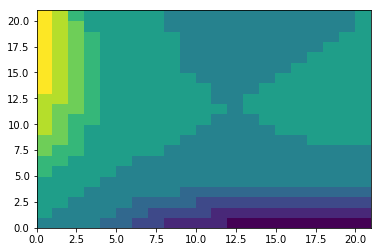

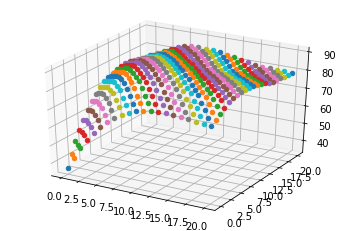

In [133]:
V, p = policy_iteration()
print(V)
print(p)

# ax = sns.heatmap(p,	 linewidth=0.5)
plt.pcolor(p)
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(max_no_of_cars+1):
    for j in range(max_no_of_cars+1):
        ax.scatter(i, j, V[i, j])

plt.show()